In [224]:
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import openai
from sentence_transformers import SentenceTransformer, util
from lxml import html as hm
import requests
from lxml import etree
import numpy as np
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

In [ ]:
sections = ['Navigation', 'Product Info', 'Product Images', 'Checkout Options', 'shopping cart', 'other']

similarityThreshold = 0.3
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

# HELPER FUNCTIONS

In [260]:
openai.api_key = os.getenv("OPENAI_API_KEY")

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    
    if str(element).strip() == "":
        return False
    
    return True


def visible_node(node):
    if node.tag in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    
    if node.tag is etree.Comment:
        return False
    
    if node.text == None or node.text.strip() == "":
        return False
    
    return True


def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return texts, u" ".join(t.strip() for t in visible_texts)


def queryOracle(text, prompt):
    sectionsOfInterest = ", ".join(sections[:-1]) + " and " + sections[-1]
    prompt = prompt.format(sectionsOfInterest)
    completion = openai.ChatCompletion.create(
    model = "gpt-4",
    temperature = 0.8,
    max_tokens = 2000,
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": text}
    ]
    )
    return completion

def bert_sim(text1, text2):
    embeddings = model.encode([text1,text2])
    res = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return res.numpy()[0][0] 


def classify(code):
    elements, readableText = text_from_html(code)
    elements = list(filter(tag_visible, elements))
    # prompt = "You are a webpage analyzer. You find sections of text on an e-commerce webpage that correspond to {}"
    prompt = "You are a webpage analyzer. You will be given readable text from an HTML DOM Tree of an e-commerce website in the form: Text For Node 1, Text For Node 2, Text for Node 3. Classify the nodes into the following categories: {}"
    prompt += ". Return the classification in the following format: Class1: Text for node 1, Text for node 2 Class2: Text for node 3"

    response = queryOracle(readableText, prompt).choices[0].message
    tree = hm.fromstring(code)
    capSections = [i.title() for i in sections]

    parts = []
    inds = []
    for count, i in enumerate(capSections):
        p = response.content.find(i, 0)
        start = p+len(i)+1
        inds.append(p+len(i)+1)
        sub = response.content[start : len(response.content)]
        parts.append(sub)
        if (count > 0):
            parts[count-1] = parts[count-1][0: p - inds[count-1]]

    nodes = []
    nodeMap = {}
    count = 0
    for i in tree.getiterator():
        nodes.append(i)
        nodeMap[i] = count
        count +=1


    # for i in nodes:
    nodes = list(filter(visible_node, nodes))
    nodetext = [i.text.strip() for i in nodes]


    domCode = {}
    for count, section in enumerate(sections[:-1]):
        print("Finding HTML Code for {} Section".format(section))
        l = len(parts[count])
        res = []
        vals = []
        for i in nodetext:
            em = bert_sim(i, parts[count])
            res.append(em)
            vals.append(i)

        inds = [nodes[c] for c, i in enumerate(res) if i > similarityThreshold]
        scores = [i for i in res if i > similarityThreshold]
        inds = [nodeMap[i] for i in inds]
        domCode[section] = (inds, scores)

    return domCode

def processPred(d, size):
    res = [6 for i in range(size)]

    allInds = []
    allIndsScoring = []
    reference = []

    for count, i in enumerate(d):
        c = 0
        for j in d[i][0]:
            # print(d[i])
            # print(j)
            res[j] = count
            allInds.append(j)
            allIndsScoring.append(d[i][1][c])
            reference.append(count)
            c+=1

    def list_duplicates(seq):
        tally = defaultdict(list)
        for i,item in enumerate(seq):
            tally[item].append(i)
        return ((key,locs) for key,locs in tally.items() 
                                if len(locs)>1)

    rep = []
    for dup in sorted(list_duplicates(allInds)):
        rep.append(dup)

    for i in rep:

        maxInd = 0
        score = 0
        for j in i[1]:
            if score < allIndsScoring[j]:
                maxInd = j
        ref = reference[maxInd]
        # print(ref)
        # print(d[ref[0]][0][ref[1]])
        res[i[0]] = ref
    
    # print(res)
    
    return res 

   

# SCRAPE PAGE & FIND CONTENT SECTIONS

In [150]:
html = urllib.request.urlopen('https://boxbox.in/products/copy-of-boxbox-oversized-t-shirt-44-lewis-hamilton-1').read()
elements, readableText = text_from_html(html)
elements = list(filter(tag_visible, elements))
response = queryOracle(readableText).choices[0].message
response

/var/folders/ys/yk2qwk_x4nqdv328vt6g5kxr0000gn/T/ipykernel_18492/3647402521.py:31: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texts = soup.findAll(text=True)


KeyboardInterrupt: 

In [159]:
for i in d['urls'][30:31]:
    tree = hm.fromstring(d['code'][i])
    elements, readableText = text_from_html(d['code'][i])
    elements = list(filter(tag_visible, elements))
    # response = queryOracle(readableText).choices[0].message

# response

nodes = []
for i in tree.getiterator():
    nodes.append(i)


nodeList = list(filter(visible_node, nodes))
nodeList = [node.text.strip() + "," for node in nodeList]
print(nodeList)

['Skip to main content,', 'Get extra 30% off select styles! Code FRIEND.,', 'Shop Now,', 'Gift Registry,', 'Shop Your Store,', 'Sign In,', '0,', 'Women,', 'Men,', 'Kids,', 'Home,', 'Beauty,', 'Shoes,', 'Handbags,', 'Jewelry,', 'Furniture & Mattresses,', 'Toys,', 'Gifts,', 'Trending,', 'Sale,', "Women's Clothing,", "All Women's Clothing,", 'New Arrivals,', 'Activewear,', 'Blazers,', 'Bras, Underwear & Lingerie,', '100% Cashmere,', 'Coats & Jackets,', 'Dresses,', 'Hoodies & Sweatshirts,', 'Jeans,', 'Jumpsuits & Rompers,', 'Pajamas & Robes,', 'Pants & Capris,', 'Skirts,', 'Suits & Suit Separates,', 'Sweaters,', 'Swimsuits & Cover-Ups,', 'Tops,', 'Juniors,', "All Juniors' Clothing,", 'Coats & Jackets,', 'Dresses,', 'Jeans,', 'Sweaters,', 'Tops,', 'Plus Sizes,', 'All Plus Size Clothing,', 'Coats & Jackets,', 'Dresses,', 'Pants,', 'Sweaters,', 'Tops,', 'More Sizes,', 'Petites (5\'4" & Under),', 'Maternity,', 'Complete Your Look,', 'Shoes,', 'Handbags & Wallets,', 'Accessories,', 'Beauty & Fr

/var/folders/ys/yk2qwk_x4nqdv328vt6g5kxr0000gn/T/ipykernel_18492/80449784.py:31: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texts = soup.findAll(text=True)


In [160]:
prompt = "You are a webpage analyzer. You will be given readable text from an HTML DOM Tree of an e-commerce website in the form: Text For Node 1, Text For Node 2, Text for Node 3. Classify the nodes into the following categories: {}"
prompt += ". Return the classification in the following format: Class1: Text for node 1, Text for node 2 Class2: Text for node 3"
response = queryOracle("\n".join(nodeList), prompt).choices[0].message

In [168]:
sections = ['Navigation', 'Product Info', 'Product Images', 'Checkout Options', 'shopping cart', 'other']
sectionsOfInterest = ", ".join(sections[:-1]) + " and " + sections[-1]
prompt = "You are a webpage analyzer. You will be given readable text from an HTML DOM Tree of an e-commerce website in the form: Text For Node 1, Text For Node 2, Text for Node 3. Classify the nodes into the following categories: {}".format(sectionsOfInterest)
prompt += ". Return the classification in the following format: Class1: Text for node 1, Text for node 2 Class2: Text for node 3"
print(prompt)

You are a webpage analyzer. You will be given readable text from an HTML DOM Tree of an e-commerce website in the form: Text For Node 1, Text For Node 2, Text for Node 3. Classify the nodes into the following categories: Navigation, Product Info, Product Images, Checkout Options, shopping cart and other. Return the classification in the following format: Class1: Text for node 1, Text for node 2 Class2: Text for node 3


In [161]:
print(response)

{
  "role": "assistant",
  "content": "Navigation: Skip to main content, Shop Now, Gift Registry, Shop Your Store, Sign In, 0, Women, Men, Kids, Home, Beauty, Shoes, Handbags, Jewelry, Furniture & Mattresses, Toys, Gifts, Trending, Sale, Shop by Department, Womens Clothing, Mens Clothing, Kids Clothing, For The Home, Shoes, Handbags & Accessories, Beauty, Furniture, Bed & Bath, Jewelry, Watches, Juniors, Plus Size Clothing, Petite Clothing, Baby Products, Sale & Clearance\n\nPage Heading: Polo Ralph Lauren, Men's Polo Player Pajama Pants\n\nBuying Selections: Please select a color, Beach Blue, Black/Red, Black/White, Navy, Current selected color: Black/White, Color:, Black/White, This shade is your, best match, Size:, Please select, Size Chart, S, M, L, XL, $38.50, $55.00, Details, Add To Bag, Buy Now, Product Details, Materials & Care, Machine washable, All cotton, Shipping & Returns, This item qualifies for Free Shipping with minimum purchase!\n\nCheckout Options: Add To Bag, Buy Now

In [137]:
res = requests.get("https://boxbox.in/products/copy-of-boxbox-oversized-t-shirt-44-lewis-hamilton-1")
f = open('test.html', 'w')
f.write(res.text)
f.close()
tree = hm.fromstring(res.text)

In [40]:
capSections = [i.title() for i in sections]

parts = []
inds = []
for count, i in enumerate(capSections):
    p = response.content.find(i, 0)
    start = p+len(i)+1
    inds.append(p+len(i)+1)
    sub = response.content[start : len(response.content)]
    parts.append(sub)
    if (count > 0):
        parts[count-1] = parts[count-1][0: p - inds[count-1]]


parts

[' "Skip to content", "Home Formula 1 Formula 1 T-shirts Oversized T-shirts Sweatshirts Hoodies Football Football T-shirts Oversized T-shirts Contact About Us Blogs Smiles Log in Instagram Search Log in Cart"\n\n',
 ' "Oversized T-shirt Lewis Hamilton Sketch"\n\n',
 ' "Size S Variant sold out or unavailable M Variant sold out or unavailable L Variant sold out or unavailable XL Variant sold out or unavailable Color Black Variant sold out or unavailable White Variant sold out or unavailable", "Product variants S / Black - Rs. 999.00 S / White - Rs. 999.00 M / Black - Rs. 999.00 M / White - Rs. 999.00 L / Black - Rs. 999.00 L / White - Rs. 999.00 XL / Black - Rs. 999.00 XL / White - Rs. 999.00", "Quantity ( 0 in cart) Decrease quantity for boxbox Oversized T-shirt Lewis Hamilton Sketch Increase quantity for boxbox Oversized T-shirt Lewis Hamilton Sketch Add to cart"\n\n',
 ' "Your cart is empty Continue shopping Have an account? Log in to check out faster. Your cart Loading... Subtotal Rs

# FIND HTML CODE FOR CONTENT SECTIONS

In [47]:
code = {}
for count, section in enumerate(sections):
    print("Finding HTML Code for {} Section".format(section))
    l = len(parts[count])
    res = []
    vals = []
    for i in elements:
        em = bert_sim(i.text, parts[0])
        res.append(em)
        vals.append(i.text)

    inds = [c for c, i in enumerate(res) if i > similarityThreshold]
    code[section] = [elements[i].parent for i in inds]


Finding HTML Code for navigation Section
Finding HTML Code for page heading Section
Finding HTML Code for buying selections Section
Finding HTML Code for checkout options Section


In [45]:
nodeinds = []
nodetext = []
count = 0
for i in tree.getiterator():
    s = i.text
    if (s != None and s != "None"):
        s = s.strip()
        if (s != "\n" and s != " "):
            nodeinds.append(count)
            nodetext.append(s)
    count += 1

In [55]:
domCode = {}
for count, section in enumerate(sections):
    print("Finding HTML Code for {} Section".format(section))
    l = len(parts[count])
    res = []
    vals = []
    for i in nodetext:
        em = bert_sim(i, parts[0])
        res.append(em)
        vals.append(i)

    inds = [nodeinds[c] for c, i in enumerate(res) if i > similarityThreshold]
    # code[section] = [elements[i].parent for i in inds]
    domCode[section] = inds

Finding HTML Code for navigation Section
Finding HTML Code for page heading Section
Finding HTML Code for buying selections Section
Finding HTML Code for checkout options Section


In [4]:
domCode["navigation"]

NameError: name 'domCode' is not defined

# END PROTOTYPING

# BEGIN EXPERIMENTS

In [ ]:
import json

f = open('../Dataset/data.json', 'r')
val = f.read()
f.close()

d = json.loads(val)

In [ ]:
pred = {}
count = 0
for i in d['urls'][0:40]:
    print(count)
    count+= 1
    res = classify(d['code'][i])
    pred[i] = res

In [ ]:
with open('../Dataset/pred.pkl', 'wb') as file:
    pickle.dump(pred, file)

# Tests

In [76]:
import json

f = open('../Dataset/data.json', 'r')
val = f.read()
f.close()

d = json.loads(val)

In [178]:
with open("../Dataset/pred.pkl", "rb") as file:
  pred = pickle.load(file)

In [262]:
acc = []
fscore = []
totalPred = []
totalActual = []
for i in pred:
    actual = d["labels"][i]
    procPred = processPred(pred[i], len(actual))
    # print(procPred)
    acc.append(np.sum(np.equal(actual, procPred))/len(actual))
    fscore.append(fbeta_score(actual, procPred, average='weighted', beta=0.5))
    totalActual.extend(actual)
    totalPred.extend(procPred)
    # print(procPred)
    

print(sum(acc)/len(acc))
print(sum(fscore)/len(fscore))

0.3174635778530463
0.18248991399349185


In [263]:
print(fbeta_score(totalActual, totalPred, average='weighted', beta=0.5))
print(np.sum(np.equal(totalActual, totalPred))/len(totalActual))

0.18953458647627575
0.3202531941232803


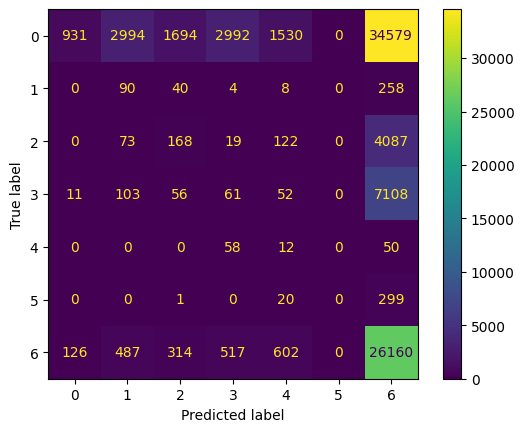

In [264]:
cm_matrix = confusion_matrix(totalActual, totalPred)
cm = ConfusionMatrixDisplay(confusion_matrix = cm_matrix)
cm.plot()
plt.show()